# Agentes y sistemas multi-agente

In [1]:
# Instala las dependencias
# !poetry add langgraph langchain langchain-openai langchain-core langchain-community pandas matplotlib langchain-experimental

# Carga las variables de ambiente
from dotenv import load_dotenv

load_dotenv()

True

## Agentes

### ¿Qué es un agente?

Software capaz de utilizar a los LLMs como motor de razonamiento que ejecuta acciones por sí solo, recabando datos o interactuando con herramientas,  y llevando a cabo tareas complejas de principio a fin.

### ¿Cómo programar un agente?

En nuestro caso, estamos creando un agente encargado de la ejecución de cálculos matemáticos, pues bien sabemos que los LLMs son terribles en este campo.

Primero plasmamos en un prompt el rol del agente o su personalidad y las metas u objetivos que debe cumplir. En nuestro caso, estamos creando un agente encargado de la ejecución de cálculos matemáticos, pues bien sabemos que los LLMs son terribles en este campo.

In [2]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """Eres una calculadora avanzada y de última tecnología.
Tu objetivo es extraer la operación matemática del input del usuario y escribirla en Python.
Luego debes ejecutar la operación con la función dada para este propósito y dar una respuesta precisa.
===
Pregunta del usuario: {input}
===
"""

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        MessagesPlaceholder(variable_name="agent_scratchpad"), # Memoria funcional del Agente

    ]
)

Segundo, debes implementar las herramientas que están al alcance del agente. En nuestro caso, crearemos una herramienta para evaluar operaciones matemáticas escritas en sintaxis de Python

In [3]:
def calculation_func(operation: str) -> float:
    """
    Ejecuta la operación matemáticas recibida en sintaxis de Python.

    Args:
        operation (str): La operación matemática a ejecutar.

    Returns:
        float: El resultado de la operación.
    """
    print("Operación recibida:", operation)
    return eval(operation)


A partir de nuestra herramienta creamos un `StructuredTool`, una abstracción de LangChain, que encapsula a las funciones, y las documenta bien, para que los agentes hagan uso de ellas.

In [4]:
from langchain_core.tools import StructuredTool

calculation_tool = StructuredTool.from_function(
    func=calculation_func,
    name="ExecuteMathOperation",
    description="Usa esta función para ejecutar operaciones matemáticas escritas en sintaxis de Python.",
)

tools = [calculation_tool]

Ahora solo es cuestion de poner las piezas juntas utilizando las abstracciones proveidas por LangChain y LangGraph para este proposito. 

En este caso, utilizamos la funcion `create_openai_functions_agent` y especificamos que LLM deseamos sea el motor de razonamiento, que herramientas estan disponibles, y el prompt del sistema

In [5]:
import os
from langchain_openai import AzureChatOpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.pydantic_v1 import SecretStr

llm = AzureChatOpenAI(
    api_key=SecretStr(os.environ["AZURE_OPENAI_API_KEY"]),
    azure_endpoint=os.environ["AZURE_OPENAI_API_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment="gpt-4",
)

agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools) # type: ignore

In [6]:
agent_executor.invoke({
    "input": "¿Cuál es el área de un círculo de radio 3?",
    "chat_history": [],	
})

Operación recibida: 3.141592653589793 * (3 ** 2)


{'input': '¿Cuál es el área de un círculo de radio 3?',
 'chat_history': [],
 'output': 'El área de un círculo con un radio de 3 es aproximadamente 28.27 unidades cuadradas.'}

## Sistemas multi-agente

Un sistema multi-agente, es una colección de agentes especializados que trabajan en conjunto para la ejecución exitosa de una tarea compleja, simulando en muchas veces como nosotros los humanos dividimos el trabajo.

### ¿Cómo programar un sistema multi-agente?

Para lograrlo, existen igualmente una infinidad de librerías, entre las que se destacan CrewAI, AutoGen y LangGraph. Para el propósito de nuestro demo, usaremos LangGraph.

Programemos entonces un sistema multi-agente, y llevemos las capacidades de nuestra demostración al siguiente nivel: Crearemos un sistema capaz de explicar complejos conceptos matemáticos de manera escrita y de manera gráfica.

Vamos entonces a tener tres agentes: El primero es un profesor, que buscará en sus datos de entrenamiento y la web los conceptos detrás de un tema matemático que deseamos sea explicado.

En segundo lugar, tenemos a un desarrollador, que implementará código Python para simular el concepto matemático solicitado.

Y finalmente, el tercer agente, es un supervisor encargado de orquestar los esfuerzos de los especialistas y lograr la consecución del objetivo.

#### 1. Agente profesor

Empecemos por nuestro primer agente: realizamos la creación del prompt, estableciendo su personalidad y sus metas.

Y al igual que nuestro ejemplo anterior, nuestro agente tendrá acceso al historial del chat y al scratchpad que serán añadidos en el input enviado al LLM.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


mathematician_prompt_template = """Eres un profesor veterano de matemáticas.
Los estudiantes solicitarán que les expliques temas y conceptos matemáticos complejos.
Tu objetivo es explicar estos conceptos de la forma más sencilla posible.
Si no tienes la respuesta, puedes usar el buscador de Tavily para encontrar la respuesta en la web.
¡Fuiste escogido por una razón!
No pidas clarificaciones, solo responde a la pregunta.
"""

mathematician_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            mathematician_prompt_template
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        MessagesPlaceholder(variable_name="agent_scratchpad"), # Memoria funcional del Agente

    ]
)

El profesor tendrá acceso a una herramienta pre-construida y disponible dentro de las capacidades de LangChain.

Esta herramienta hace uso de `TavilySearch`, un buscador que les permite a los agentes explorar la web y llenar cualquier vacío que tengan en sus datos de entrenamiento.

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search_tool = TavilySearchResults(max_results=5)

Ya con estos dos elementos, podemos proceder a crear el Agente, del mismo modo que en nuestro ejercicio pasado

In [9]:
from langchain.agents import AgentExecutor, create_openai_functions_agent

professor_tools = [tavily_search_tool]
professor_agent = create_openai_functions_agent(llm, professor_tools, mathematician_prompt)
professor = AgentExecutor(agent=professor_agent, tools=professor_tools)  # type: ignore

Posteriormente, creamos la personalidad y metas de nuestro agente desarrollador, un especialista en la creación de código Python capaz de simular e ilustrar los complejos conceptos matemáticos preguntados.

Después creamos una instancia de nuestro `ChatPromptTemplate` con los mismos parámetros de nuestros agentes anteriores.

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


developer_prompt_template = """Eres un experto en matemáticas y desarrollo de software.
Los usuarios solicitarán que generes conjuntos de datos que simulen el comportamiento de una función matemática.
Puedes generar código en Python que genere estos datos y luego ejecutarlo para obtener los resultados.
Puedes usar Matplotlib en las herramientas que tienes a tu disposición y visualizar los datos generados.
Usa la herramienta para ejecutar el código y obtener los resultados.
¡Fuiste escogido por una razón!.
No pidas clarificaciones, solo responde a la pregunta.
"""

developer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            developer_prompt_template
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        MessagesPlaceholder(variable_name="agent_scratchpad"), # Memoria funcional del Agente

    ]
)

Procedemos ahora, a implementar las herramientas, en este caso, un método en Python que le permitirá la ejecución de código al agente y mostrará gráficas con la ayuda de `NumPy` y `Matplotlib`, dos librerías de análisis estadístico y matemático, extremadamente populares en Python.

In [11]:
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

def python_repl_func(
    code: str,
) -> str:
    """
    Usa este método para ejecutar código Python.
    Si deseas ver la salida de un valor, debes imprimirlo con `print(...)`.
    Esto es visible para el usuario.
    Usa Matplotlib para visualizar los datos generados.

    Args:
        code (str): El código Python a ejecutar.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"La ejecución fallo. Error: {repr(e)}"
    return f"Ejecución exitosa:\n```python\n{code}\n```\nStdout: {result}"

python_code_execution_tool = StructuredTool.from_function(
    func=python_repl_func,
    name="ExecutePythonCode",
    description="Usa este metodo para ejecutar código Python.",
)


Y nuevamente instanciamos el agente junto con sus herramientas y su `AgentExecutor`

In [12]:
from langchain.agents import AgentExecutor, create_openai_functions_agent

developer_tools = [python_code_execution_tool]
developer_agent = create_openai_functions_agent(llm, developer_tools, developer_prompt)
developer = AgentExecutor(agent=developer_agent, tools=developer_tools)  # type: ignore

Y llegó el momento de crear a nuestro supervisor, un agente cuyo trabajo es bastante simple: definir a qué miembro del equipo llamar, para solucionar el problema dado.

En nuestro caso, estará en la potestad de llamar al profesor para explicar los conceptos, y una vez claros, al desarrollador para demostrarlos desde una perspectiva gráfica.

Es su trabajo también decidir cuándo el trabajo se ha completado exitosamente, y finalizar la acción del equipo.

En la creación del supervisor, tomamos ventaja de la funcionalidad de OpenAI denominada, `function calling`.

Esta capacidad permite especificar funciones que el LLM puede ejecutar de manera remota, y retornara una respuesta estructurada, en este caso, un JSON con un atributo `next`, que especifica la decisión del supervisor, en cuanto a quién debe ser llamado ahora para ejecutar el siguiente paso.

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

options = ["FINISH", "profesor", "desarrollador"]
function_def = {
    "name": "route",
    "description": "Selecciona el siguiente rol.", 
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [{
                    "enum": options,
                }],
            },
        },
        "required": ["next"],
    },
}

supervisor_prompt_template = """Eres el supervisor de una academia de matemáticas.
Tu deber es manejar la conversación entre los siguientes trabajadores: {workers}
Dado el siguiente request de un estudiante, debes responder con el nombre del experto que debe actuar ahora.
Cada experto va a ejecutar una tarea y responder con sus resultados y status
Cuando todo haya terminado, debes responder con FINISH."""
supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", supervisor_prompt_template),
    MessagesPlaceholder(variable_name="chat_history"),
    (
        "system", 
        "Dada la conversación arriba,"
        "¿Quién debería actuar ahora?" 
        "¿O deberíamos terminar con FINISH?"
        "Selecciona una de las opciones: {options}"
    ),
]).partial(options=str(options), workers=", ".join(["profesor", "desarrollador"]))

El supervisor será ejecutado a través de una cadena de LangChain, que especifica su prompt, el LLM junto con su configuración, en este caso, la ejecución de la función definida, y finalmente el procesamiento de la respuesta generada en formato JSON.

In [14]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

supervisor_chain = (
    supervisor_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

Ahora debemos poner todas las piezas juntas utilizando un grafo de LangGraph, es decir, una estructura que, a partir de nodos y aristas, específica como interactúan nuestros agentes.

Cada nodo corresponde a un agente disponible y cada arista representa la función de activación de los nodos, en este caso, la decisión del supervisor.

LangGraph permite la implementación de grafos stateful o con estado, es decir, conserva en memoria el historial de cada salto entre nodos, además del output de cada paso ejecutado.

Permitiendo la reejecución de pasos independientes del grafo, y ayudándonos a entender cómo los datos se transformaron a lo largo del viaje entre las aristas y los nodos.

Esto lo logra a partir de la instanciación de una clase de estado, un objeto compartido y modificado durante la ejecución, y que, en caso de error, conserva los datos del último paso exitoso.

Hagamos entonces la implementación del estado de nuestra aplicación, en este caso, una clase que se asemeja a un diccionario, y que conserva el historial de mensajes, y el siguiente paso a ejecutar.

In [15]:
import operator
from typing import Sequence, TypedDict, Annotated
from langchain_core.messages import BaseMessage

# El estado del agente es el input de cada nodo en el grafo
class AgentState(TypedDict):
    # La anotación le indica al grafo que todo nuevo mensaje o output de su ejecución
    # seran añadidos a la conversación
    chat_history: Annotated[Sequence[BaseMessage], operator.add]
    # El campo `next`, indica el siguiente nodo a ejecutar
    next: str

Y ya casi tenemos todo listo para construir nuestro grafo, nos hace falta solo un pequeño detalle: debemos crear una función que especifique cómo lucirán los nodos en el grafo, y que se hace cargo de convertir la respuesta del agente, en un `AIMessage`, es decir, una entrada añadida al historial de chat que hace parte del estado del grafo.

Esta función espera el objeto con el estado actual, el agente que se va a ejecutar, y el nombre que recibirá el nodo.

In [16]:
import uuid
from typing import Any
from langchain.agents import AgentExecutor
from langchain_core.messages import AIMessage

def agent_node(
    state,
    agent: AgentExecutor,
    name: str,
) -> dict[str, Any]:
    """
    Función que ejecuta el agente al ingresar al nodo de un grafo.

    Args:
        state: El objeto que contiene el estado del grafo
        agent(AgentExecutor): El agente a ejecutar
        name(str): El nombre del nodo

    Returns:
        dict: La respuesta del agente
    """
    result = agent.invoke(state)
    return {
        "chat_history": [
            AIMessage(
                id=str(uuid.uuid4()),
                content=result["output"],
                name=name,
            )
        ]
    }

Y ahora sí, podemos poner todas nuestras piezas juntas y crear el famosísimo grafo.

Creamos los nodos de nuestros agentes profesor y desarrollador  con ayuda de la función agent_node creada.

In [17]:
import functools

# Primero creamos nuestros nodos usando la función `agent_node`. 
professor_node = functools.partial(agent_node, agent=professor, name="profesor") 
developer_node = functools.partial(agent_node, agent=developer, name="desarrollador")

Añadimos los nodos al grafo: el `supervisor` enlazado a la cadena que creamos para su ejecución, y el `profesor` y el `desarrollador` enlazados a sus nodos respectivos.

Y añadimos las aristas, que especifican que el `supervisor` se puede comunicar con el `profesor` y también con el `desarrollador`.

In [18]:
from langgraph.graph import END, StateGraph

# Primero creamos el grafo
graph = StateGraph(AgentState)

# Luego añadimos los nodos al grafo
graph.add_node("supervisor", supervisor_chain) # El supervisor usa el chain creado
graph.add_node("profesor", professor_node)
graph.add_node("desarrollador", developer_node)

# Finalmente añadimos las aristas que conectan los nodos
# En este caso, el profesor y el desarrollador se comunican con el supervisor
graph.add_edge("profesor", "supervisor")
graph.add_edge("desarrollador", "supervisor")

Para poder realizar la navegación a través de las aristas del grafo, se crea un mapa condicional y los `conditional_edges`, es decir, lógica que le instruye a LangGraph, que a través del atributo next de la respuesta del supervisor se dará salto al nodo siguiente.

In [19]:
from langgraph.graph import END

# Creación del mapa condicional
conditional_map = {k: k for k in ["profesor", "desarrollador"]}
conditional_map["FINISH"] = END
print("Mapa condicional:", conditional_map)

# Añadimos las aristas condicionales al grafo
graph.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map) # type: ignore

Mapa condicional: {'profesor': 'profesor', 'desarrollador': 'desarrollador', 'FINISH': '__end__'}


Y finalmente especificamos cuál es el nodo inicial del grafo, en nuestro caso, el `supervisor`

In [20]:
from langgraph.graph import START

graph.add_edge(START, "supervisor")

Ya con esto tenemos todo listo, compilamos nuestro grafo.

In [21]:
agent_team = graph.compile()

Y si deseamos verificar que es correcto, podemos graficarlo para validar su configuración.

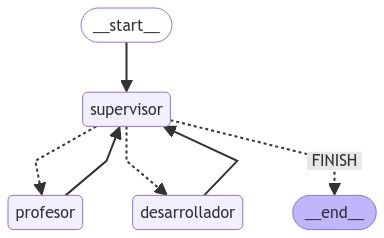

In [22]:
from IPython.display import Image, display

display(Image(agent_team.get_graph().draw_mermaid_png(), width=620))

Y ahora podemos invocar nuestro sistema multi-agente. Esto incluye también algo de magia de LangGraph: necesitas crear una configuración de ejecución y asignar a la nueva conversación un identificador único.

Y a través del método `stream()` de nuestro sistema multi-agente, podremos ver en tiempo real, cada respuesta e interacción del `supervisor` con el `profesor` y el `desarrollador`

En dicho método enviamos el mensaje inicial de la conversación. En este caso, le solicitamos a nuestro sistema que nos explique de manera sencilla la tangente de un ángulo.

================================ Human Message =================================

¿Podrías explicarme de manera sencilla la tangente de un ángulo?
                ¿Puedes ilustrarme el concepto de manera gráfica?
----
Next:  profesor
================================== Ai Message ==================================
Name: profesor

Claro, explicarte la tangente de un ángulo de manera sencilla es un placer.

Imagina que tienes un triángulo rectángulo (uno de sus ángulos es de 90 grados). La tangente de uno de los ángulos agudos de este triángulo se define como la razón entre el cateto opuesto a ese ángulo y el cateto adyacente al mismo.

Gráficamente, piensa en un sistema de coordenadas cartesianas con un círculo unitario (un círculo con radio 1) centrado en el origen (0,0). Cualquier ángulo puede trazarse desde el origen hacia un punto en el borde del círculo. Si ese ángulo está en la posición estándar (comenzando desde el eje positivo x y abriéndose hacia arriba), la tangente del ángulo 

Python REPL can execute arbitrary code. Use with caution.


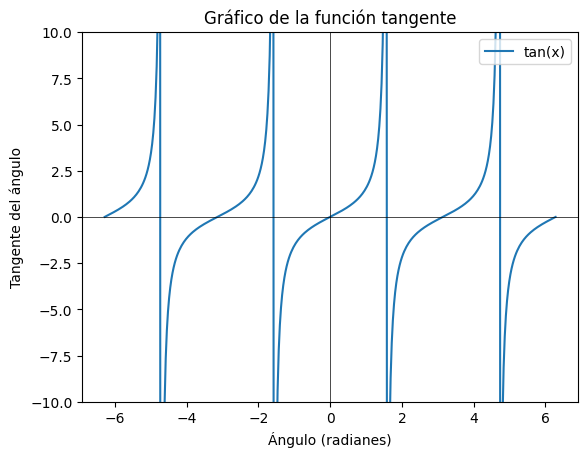

================================== Ai Message ==================================
Name: desarrollador

Aquí tienes el gráfico de la función tangente:

![Gráfico de la función tangente](sandbox:/mnt/data/tangent_plot.png)

En este gráfico, el eje horizontal representa el ángulo en radianes y el eje vertical representa el valor de la tangente de ese ángulo. Puedes ver cómo la función tangente se vuelve indefinida (tiende a infinito o negativo infinito) cerca de múltiplos impares de π/2 (como π/2, 3π/2, etc.), que son los puntos donde el coseno es cero y la tangente, que es el seno dividido por el coseno, no está definida. Además, puedes observar la periodicidad de la función con un patrón que se repite cada π radianes.
----
Next:  FINISH


In [23]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

already_printed = []
thread_id = str(uuid.uuid4())
config = RunnableConfig(
    {
        "recursion_limit": 100, # No permitir más de 100 saltos entre nodos
        "configurable": {
            # Los checkpoints son accedidos mediante el thread_id
            "thread_id": thread_id,
        },
    }
)

for event in agent_team.stream(
    {
        "chat_history": [
            HumanMessage(
                id=str(uuid.uuid4()),
                content="""¿Podrías explicarme de manera sencilla qué es la tangente de un ángulo?
                ¿Puedes ilustrarme el concepto de manera gráfica?""",
            )
        ],
    },
    config,
    stream_mode="values",
):
    if "__end__" not in event:
        history = event.get("chat_history", [])
        message = history[-1]
        if message.id in already_printed:
            print("Next: ", event.get("next"))
            continue
        print(message.pretty_repr(html=True))
        print("----")
        already_printed.append(message.id)